<a href="https://colab.research.google.com/github/ussvarma/time_series_analysis/blob/main/Model_2_Company's_expenditure_forecasting_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement:
Title - Forecast next 12 month spend based on past spend data

You need to create a system to forecast the spend of a company based on the past historical data of the last 24 months on a monthly scale.

First you need to identify the various spends a company does, you can take an example of any base company and identify the various spends a company does in a complete year, and create some fictional spend numbers of that company as training data.

After that you need to identify various features you will consider to train your model, to predict or forecast the spending company would do in the next 12 months.

You need to think through the approach you will take, the features you will identify and the algorithm you will use to achieve this. For the ML model training you can create fictional data and perform the training.

# XGBoost model for single output (1 month)



## Importing libraries


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Reading dataset 


In [ ]:
df=pd.read_csv("expenditure_200.csv")
df["Date"]= pd.to_datetime(df["Date"])  ## Converting Date column's datatype into Datetime object
df=df[:-30]

In [ ]:
df.head()

,Date,Company Id,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Location,Taxes (In lakhs)
0,2005-12-01,1,49.813290,68.6616,4.05,0.056146,1.0867,0.411013,10,mumbai,5.654493
1,2006-01-01,1,50.316402,69.7872,4.05,0.125139,1.0867,0.411572,10,bangalore,5.841239
2,2006-02-01,1,55.168217,69.7872,4.05,0.146133,1.0867,0.413629,10,hyderabad,4.385695
3,2006-03-01,1,55.412300,73.1640,4.05,0.150954,1.0867,0.414765,10,mumbai,5.325510
4,2006-04-01,1,52.284027,73.1640,4.05,0.156165,1.0867,0.416054,10,bangalore,6.263992


In [ ]:
df.drop(columns=['Company Id'],inplace=True) # Dropping companyId column as it is no use

In [ ]:
df=pd.get_dummies(df) # Converting categorical variables into numerical variables

## Data preparation 


In [ ]:
# Adding lag features to data frame for making X variable
for col in df.columns:
  if col not in ["Date"]:
    for i in range(1,25):
      df[col+str(i)]=df[col].shift(+i)

In [ ]:
df.head() # Dataframe after adding lag features


,Date,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,...,Location_mumbai15,Location_mumbai16,Location_mumbai17,Location_mumbai18,Location_mumbai19,Location_mumbai20,Location_mumbai21,Location_mumbai22,Location_mumbai23,Location_mumbai24
0,2005-12-01,49.813290,68.6616,4.05,0.056146,1.0867,0.411013,10,5.654493,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-01,50.316402,69.7872,4.05,0.125139,1.0867,0.411572,10,5.841239,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-02-01,55.168217,69.7872,4.05,0.146133,1.0867,0.413629,10,4.385695,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-03-01,55.412300,73.1640,4.05,0.150954,1.0867,0.414765,10,5.325510,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-04-01,52.284027,73.1640,4.05,0.156165,1.0867,0.416054,10,6.263992,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.isnull().sum() # checking for null values

Date                                        0
Expenditure(In lakhs)                       0
Profit (In lakhs)                           0
Employee salary and benefits (In lakhs)     0
liabilities (In lakhs)                      0
                                           ..
Location_mumbai20                          20
Location_mumbai21                          21
Location_mumbai22                          22
Location_mumbai23                          23
Location_mumbai24                          24
Length: 276, dtype: int64

In [ ]:
df.dropna(inplace=True) # Dropping Nan values

In [ ]:
df.tail()

,Date,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,...,Location_mumbai15,Location_mumbai16,Location_mumbai17,Location_mumbai18,Location_mumbai19,Location_mumbai20,Location_mumbai21,Location_mumbai22,Location_mumbai23,Location_mumbai24
166,2019-10-01,91.945366,208.2360,8.1,10.293369,6.5202,0.444415,17,34.887190,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
167,2019-11-01,94.311501,209.3616,8.1,10.324048,6.5202,0.445658,17,34.515030,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
168,2019-12-01,98.919228,209.3616,8.1,10.333790,6.5202,0.447926,17,33.132712,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
169,2020-01-01,99.835793,209.3616,8.1,10.403745,6.5202,0.448354,17,32.857742,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
170,2020-02-01,111.033821,210.4872,8.1,10.438723,6.5202,0.453074,17,29.836014,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.shape

(147, 276)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 24 to 170
Columns: 276 entries, Date to Location_mumbai24
dtypes: datetime64[ns](1), float64(271), int64(1), uint8(3)
memory usage: 315.1 KB


In [ ]:
df.index=df['Date'] 
df.index = pd.to_datetime(df.index)

In [ ]:
df.drop(columns=["Date"],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147 entries, 2007-12-01 to 2020-02-01
Columns: 275 entries, Expenditure(In lakhs) to Location_mumbai24
dtypes: float64(271), int64(1), uint8(3)
memory usage: 314.0 KB


### Separating X and Y variable


In [ ]:
x=df.drop(columns=["Expenditure(In lakhs)"])
y=df["Expenditure(In lakhs)"]

### train and test split


In [ ]:
test_split=round(len(df)*0.30)
print(test_split)

44


## Creating trainx,trainy,testx,testy



In [ ]:
trainX,testX=x[:-test_split].values,x[-test_split:].values
trainY,testY=y[:-test_split].values,y[-test_split:].values
print(trainX)

[[ 99.0528       4.05         1.05053997 ...   0.           0.
    1.        ]
 [ 99.0528       4.05         1.06145291 ...   1.           0.
    0.        ]
 [100.1784       4.05         1.30102258 ...   0.           1.
    0.        ]
 ...
 [175.5936       7.0875       7.91126183 ...   1.           0.
    0.        ]
 [175.5936       7.0875       7.95938033 ...   0.           1.
    0.        ]
 [178.9704       7.0875       7.99150385 ...   0.           0.
    1.        ]]


In [ ]:
print(testX)

[[180.096        7.0875       8.09105836 ...   0.           0.
    0.        ]
 [180.096        7.0875       8.10377956 ...   0.           0.
    0.        ]
 [180.096        8.1          8.15305388 ...   1.           0.
    0.        ]
 ...
 [209.3616       8.1         10.3337901  ...   0.           0.
    0.        ]
 [209.3616       8.1         10.40374532 ...   1.           0.
    0.        ]
 [210.4872       8.1         10.43872342 ...   0.           1.
    0.        ]]


In [ ]:
print(trainX.shape,testX.shape)

(103, 274) (44, 274)


In [ ]:
print(trainY)

[ 59.198112  60.24419   59.556767  60.423519  63.113434  64.707458
  65.155777  67.372475  67.078575  68.518173  68.204353  69.10099
  68.244202  66.968987  71.392403  70.241714  72.194397  71.332626
  74.969002  73.738609  71.930389  84.951584  87.870636  92.822083
  91.018837  92.991447  99.073647  96.41362   99.018852  98.719971
  93.868156  90.650223  85.145851  86.724937  85.016335  84.249214
  92.26915   89.888077  88.418587  84.19442   84.827049  84.234268
  81.927917  83.671379  87.083588  87.571762  89.843246  90.017593
  90.635277  89.614105  89.639008  89.230545  87.671387  84.856934
  84.807121  86.391182  85.763535  85.180725  88.662674  88.144615
  88.049965  90.660187  92.807137  91.606636  93.375008  94.221832
  95.696304  95.531921  96.124702  99.243011  98.331429 100.323959
  96.363808  97.175758  94.96405   96.886841  97.444756  96.802162
  97.325203  97.634041 100.109764 101.942894  95.890579  96.906769
  93.992691  90.630295  89.300278  94.027565  94.655212  96.483

### For feature scaling


In [ ]:
print(trainX.shape,testX.shape)

(103, 274) (44, 274)


In [ ]:
print(trainY.shape,testY.shape)

(103,) (44,)


In [ ]:
# # feature scaling for x-variables
scaler_x = StandardScaler()
trainX = scaler_x.fit_transform(trainX)
testX=scaler_x.transform(testX)

In [ ]:
# #feature scaling for y-variables
scaler_y = StandardScaler()
trainY = scaler_y.fit_transform(trainY.reshape((-1,1)))
testY=scaler_y.transform(testY.reshape((-1,1)))

In [ ]:
print(trainX.shape)

(103, 274)


In [ ]:
print("trainX Shape-- ",trainX.shape)
print("testX Shape-- ",testX.shape)

trainX Shape--  (103, 274)
testX Shape--  (44, 274)


In [ ]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [-1.77518386 -1.51124608 -1.84199195 -1.99191286 -2.82124395 -1.83983151
 -0.76646421 -0.88083033  1.3938641  -0.53619026 -2.41764263 -2.23680376
 -2.27101646 -2.28643075 -2.28220467 -2.26702314 -2.30083324 -2.25120352
 -2.3480167  -2.24256099 -2.23209508 -2.16388636 -2.09853787 -2.08975477
 -1.91987437 -1.87889818 -1.73868794 -1.61124807 -1.6660906  -1.62688628
 -1.40689793 -1.39431963 -1.64953385 -1.64133042 -1.83938653 -1.89797057
 -1.90616022 -1.91447667 -1.87535372 -1.88408446 -1.84240651 -1.85039632
 -1.81131221 -1.91422905 -1.96531093 -1.96659515 -1.92222425 -1.9253395
 -1.9286327  -1.9310984  -1.97767158 -1.93250047 -1.93366547 -2.02330431
 -1.97440748 -2.0588806  -2.00903713 -2.00424283 -1.47995456 -1.44990028
 -1.42100289 -1.39319038 -1.36639825 -1.34056876 -1.31565026 -1.2915967
 -1.26836724 -1.24592587 -1.22424117 -1.20328618 -1.18303824 -1.16347905
 -1.14459468 -1.12637581 -1.10881796 -1.09192197 -1.07569452 -1.06014903
 -1.04530666 -1.03119773 -1.0178637  -1

In [ ]:
print("testX[0]-- \n",testX[0])
print("testY[0]-- ",testY[0])

testX[0]-- 
 [ 1.86048681  1.26836724  1.69675833  2.0708005   0.86334094  2.2354942
  2.07202954 -0.88083033  1.3938641  -0.53619026  0.95362273  0.83449399
  0.80135487  0.387042    0.55026865  0.76491786  1.1028808   0.97564872
  1.28247289  1.33779784  1.33438737  1.67942706  0.98223518  0.97271677
  0.86829531  0.8427796   0.55900744  0.65700612  0.88037581  1.0764769
  1.03382746  1.42623571  1.33819265  1.2097373   1.84477632  1.72223255
  1.75193541  1.78254415  1.81531141  1.74554174  1.62322118  1.65075459
  1.68002311  1.65725686  1.6833377   1.66003352  1.68720266  1.66549769
  1.69270018  1.67153227  1.64889797  1.67547062  1.6545191   1.67912241
  1.61031335  1.63276798  1.65706015  1.63559128  1.2915967   1.31565026
  1.34056876  1.36639825  1.39319038  1.42100289  1.44990028  1.47995456
  1.51124608  1.54386466  1.57791084  1.61349737  1.65075103  1.68981481
  1.7308505   1.7740419   1.81959871  1.86776126  1.91880645  1.97305515
  2.0308815   2.09272481  2.15910482  2.

In [ ]:
print("testX_shape:\n",testX.shape)
print("testY_shape:-- ",testY.shape)

testX_shape:
 (44, 274)
testY_shape:--  (44, 1)


### Model building


In [ ]:
model = xgb.XGBRegressor(learning_rate=0.9,random_state=42,n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=27)
model.fit(trainX,trainY)

[08:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, gamma=0.2, learning_rate=0.9,
             n_estimators=1000, nthread=4, random_state=42, seed=27,
             subsample=0.8)

In [ ]:
df_importances = pd.DataFrame({
        'feature': x.columns[:10],
        'importance': model.feature_importances_[:10]
    }).sort_values(by='importance', ascending=False)
# Creating dataframe for importance features

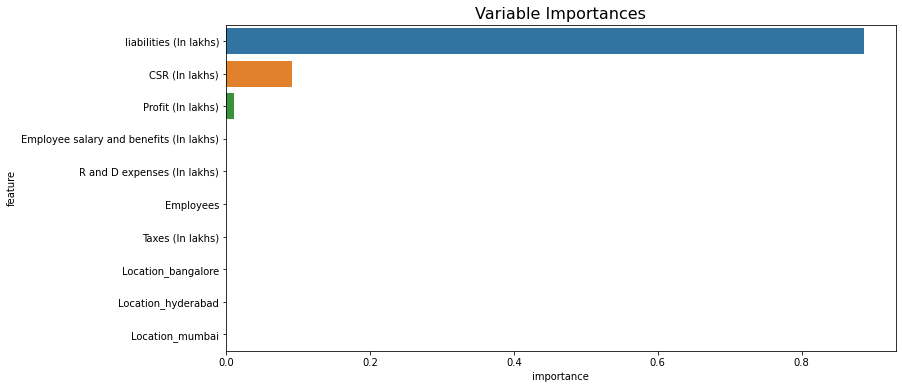

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()

### predictions on testX dataset



In [ ]:
prediction=model.predict(testX)
prediction

array([ 1.0944216 ,  0.71644723,  0.71644723,  0.17692462,  0.56772995,
        0.56772995,  0.56772995,  0.56772995,  0.56772995,  0.56772995,
        0.56772995,  0.56772995,  0.17692462,  0.17692462,  0.17692462,
        0.17692462, -0.13298434, -0.13298434, -0.13298434,  0.17692462,
        0.17692462,  0.17692462,  0.17692462,  0.17692462,  0.17692462,
        0.17692462,  0.17692462,  0.17692462,  0.17692462,  0.17692462,
        0.56772995,  0.56772995,  0.56772995,  0.71644723,  0.71644723,
        0.71644723,  0.71644723,  0.71644723,  0.56772995,  0.17692462,
        0.56772995,  1.0944216 ,  1.0944216 ,  1.3174913 ], dtype=float32)

In [ ]:
# inverse transforming to original scale
testY=scaler_y.inverse_transform(testY.reshape((-1,1)))
prediction=scaler_y.inverse_transform(prediction.reshape((-1,1)))

In [ ]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[100.28529]
 [ 95.90478]
 [ 95.90478]
 [ 89.65201]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 86.06033]
 [ 86.06033]
 [ 86.06033]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 94.18123]
 [ 89.65201]
 [ 94.18123]
 [100.28529]
 [100.28529]
 [102.87055]]

Prediction Shape- (44, 1)


In [ ]:
print("Pred Values-- " ,prediction)
print("Original Values-- ",testY)


Pred Values--  [[100.28529]
 [ 95.90478]
 [ 95.90478]
 [ 89.65201]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 86.06033]
 [ 86.06033]
 [ 86.06033]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 89.65201]
 [ 94.18123]
 [ 94.18123]
 [ 94.18123]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 95.90478]
 [ 94.18123]
 [ 89.65201]
 [ 94.18123]
 [100.28529]
 [100.28529]
 [102.87055]]
Original Values--  [[ 98.884354]
 [ 97.88311 ]
 [ 96.289085]
 [ 91.342628]
 [ 94.221832]
 [ 92.652718]
 [ 94.291573]
 [ 92.627808]
 [ 92.717468]
 [ 93.001411]
 [ 93.539391]
 [ 94.19693 ]
 [ 91.761055]
 [ 90.16703 ]
 [ 89.883095]
 [ 88.832039]
 [ 87.322693]
 [ 88.020081]
 [ 88.234276]
 [ 89.071136]
 [ 89.300278]
 [ 90.251717]
 [ 88.65271 ]
 [ 90.012611]
 [ 90.500778]
 [ 90.186958]
 [ 89.982719]
 [ 88.642746]
 

### Plot comparing testY and predictions


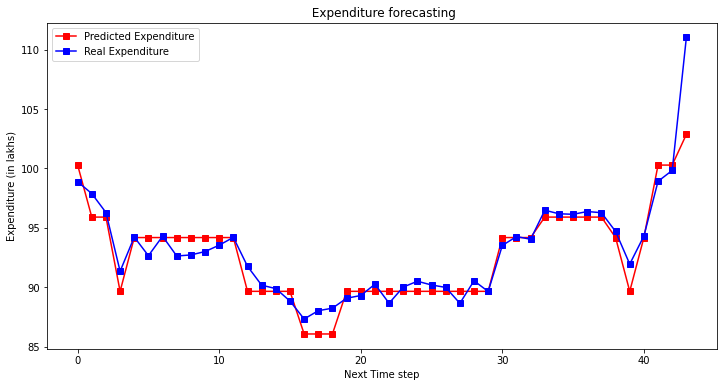

In [ ]:
#plt.xlim([100,500])
plt.figure(figsize=(12, 6))
plt.plot(prediction, color = 'red', label = 'Predicted Expenditure',marker="s")
plt.plot(testY, color = 'blue', label = 'Real Expenditure',marker="s")
plt.title(' Expenditure forecasting')
plt.xlabel('Next Time step')
plt.ylabel('Expenditure (in lakhs)')
plt.legend()
plt.show()

## Model performance

In [ ]:
from sklearn.metrics import mean_squared_error
#from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
mean_squared_error(prediction, testY)

2.5820474814587224